In [1]:
library("EpiEstim")
library("lubridate")
library("tidyverse")


Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()



Aquí alisto factores, fechas y cambio el origen a local e importado como los necesita EpiEstim:

In [2]:
Mex <- read.csv("https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/covid_mex_20200401.csv")
Mex$Date_Confirmed <- mdy(as.character(Mex$Date_Confirmed))
Mex$Date_Symptoms <- mdy(as.character(Mex$Date_Symptoms))
Mex$Origin <- if_else(Mex$Origin=="Contacto","local","imported")
Mex$Origin <- as.factor(Mex$Origin)

Limpieza y Wrangling de los datos:

In [3]:
Mex_Clean_arriba50 <- Mex %>% 
  select(-c(Tested,Age,Sex,Inconsistent,Inconsistent_New_Date,Omission,
            Omission_Last_Date,Date_Arrival,Case_ID)) %>% 
  group_by(Region,Date_Symptoms,Origin) %>% 
  summarise(casos = n())  %>% 
  ungroup() %>% 
  group_by(Region,Origin) %>% 
  mutate(acumulado = cumsum(casos))%>% 
  ungroup() %>% 
  group_by(Region) %>% 
  mutate(max = sum(casos)) %>% 
  filter(max > 50) %>% 
  select(-c(max,casos)) %>% 
  ungroup() %>% 
  rename(Estado = Region, 
         dates = Date_Symptoms, 
         Origen = Origin, 
         Incidencia = acumulado)

In [4]:
head(Mex_Clean_arriba50,15)

Estado,dates,Origen,Incidencia
<fct>,<date>,<fct>,<int>
CIUDAD DE MÉXICO,2020-02-17,local,1
CIUDAD DE MÉXICO,2020-02-22,imported,1
CIUDAD DE MÉXICO,2020-02-23,imported,2
CIUDAD DE MÉXICO,2020-02-29,imported,3
CIUDAD DE MÉXICO,2020-03-01,imported,4
CIUDAD DE MÉXICO,2020-03-02,imported,5
CIUDAD DE MÉXICO,2020-03-03,imported,6
CIUDAD DE MÉXICO,2020-03-04,imported,8
CIUDAD DE MÉXICO,2020-03-06,imported,10


In [5]:
Fechas <- rep(seq(min(Mex_Clean_arriba50$dates),max(Mex_Clean_arriba50$dates), by = "day"),length(unique(Mex_Clean_arriba50$Estado)))
Fechas_2 <- rep(Fechas,2)
Orig <- c(rep("local",length(Fechas)),rep("imported",length(Fechas)))
l <- length(seq(min(Mex_Clean_arriba50$dates),max(Mex_Clean_arriba50$dates), by = "day"))
estado <- c()
for (est in unique(Mex_Clean_arriba50$Estado)){
  estado <- c(estado, rep(est,l))
    }



helper <- tibble(
    Origen = as.factor(Orig),
    dates = Fechas_2,
    Estado = as.factor(rep(estado,2))
    )

In [6]:
Mex_filled <- Mex_Clean_arriba50 %>% 
    right_join(helper)

Joining, by = c("Estado", "dates", "Origen")

Warning message:
“Column `Estado` joining factors with different levels, coercing to character vector”


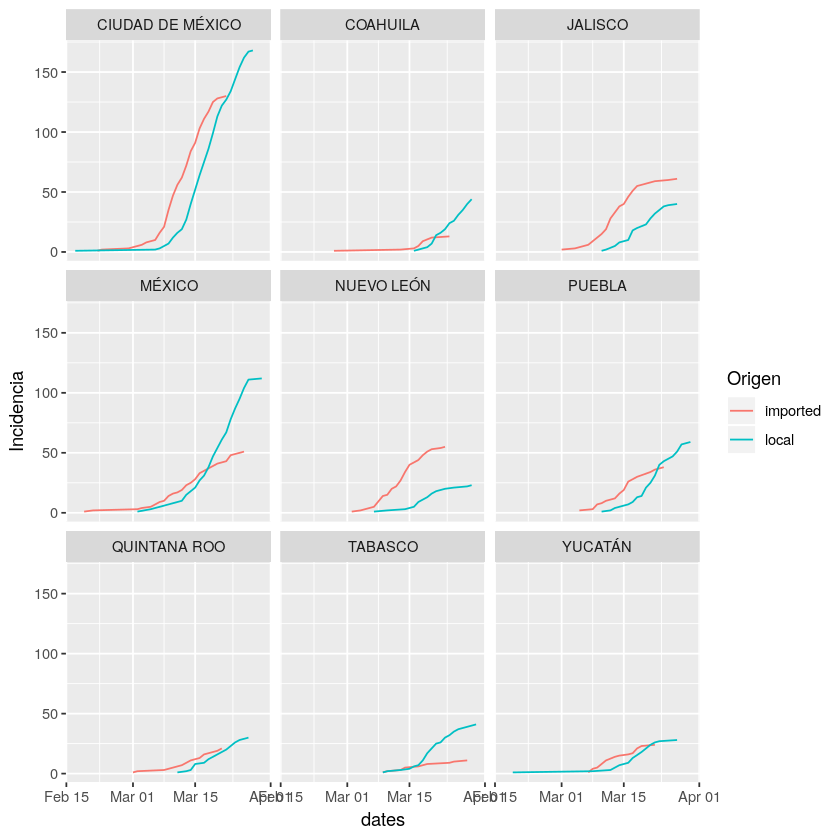

In [7]:
Mex_Clean_arriba50 %>% 
  ggplot(aes(x=dates,y=Incidencia,color=Origen))+geom_line()+facet_wrap(~Estado)
                                                                         
# Los outputs gráficos de R en jupyter siempre son horribles.                                                                        

Configuración del **SERIAL INTERVAL** según la referencia que paso lalito:

In [8]:
config <- make_config(list(mean_si = 4.7, std_mean_si = 0.5,
                           min_mean_si = 3.4, max_mean_si = 6.0,
                           std_si = 2.9, std_std_si = 0.6,
                           min_std_si = 1.9, max_std_si = 3.9))

Corrida como ejemplo de JALISCO:

* aquí me gustaría que hubiera un dropdown menú que puede seleccionar entre estos estados:

In [9]:
unique(Mex_Clean_arriba50$Estado) # esta linea diera las opciones del dropdown menú

[1] CIUDAD DE MÉXICO COAHUILA         JALISCO          MÉXICO          
[5] NUEVO LEÓN       PUEBLA           QUINTANA ROO     TABASCO         
[9] YUCATÁN         
33 Levels: AGUASCALIENTES BAJA CALIFORNIA ... ZACATECAS

suponemos seleccionamos uno:

In [10]:
state = "JALISCO"

se muestran casos importados y locales:

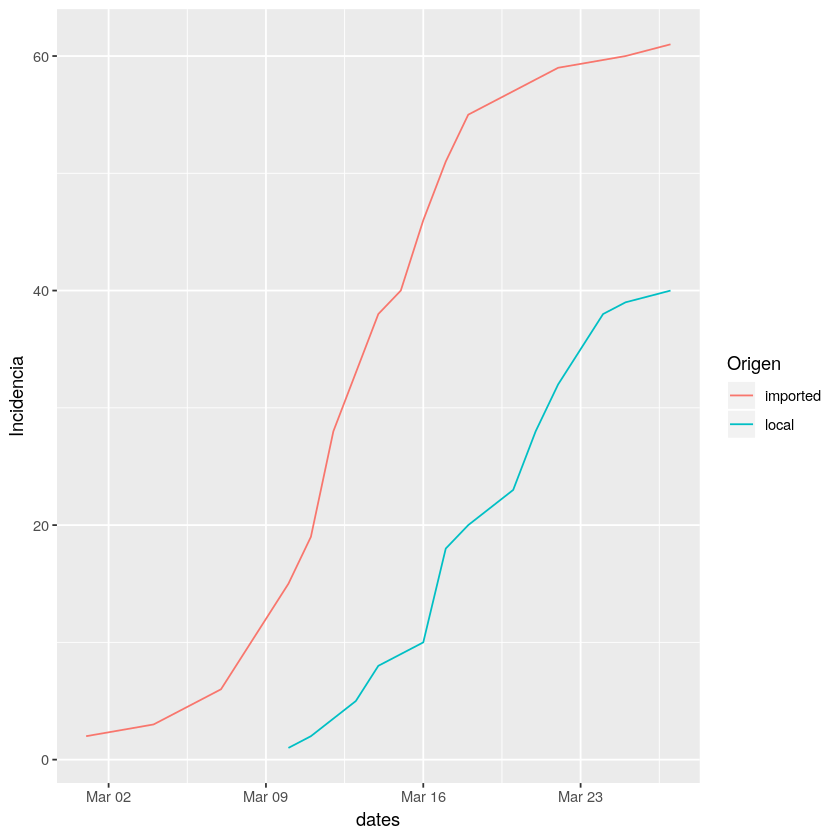

In [11]:
Mex_Clean_arriba50 %>% 
  filter(Estado == state) %>%
  ggplot(aes(x=dates,y=Incidencia,color=Origen))+geom_line()

Se obtiene y muestra Grafico de R instantaneo:

In [164]:
R <- Mex_filled %>% 
  spread(Origen,Incidencia) %>% 
  filter(Estado == state) %>% 
  select(c(dates,local,imported)) %>% 
  ungroup() %>%
  mutate(local = replace_na(local, 0)) %>% 
  mutate(imported = replace_na(imported, 0)) %>% 
  estimate_R(.,method = "uncertain_si", config = config)

R <- R$R

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”


Aquí podriamos mejorar el plot poniendo las fechas no el numero de semana que le asigna EpiEstim!

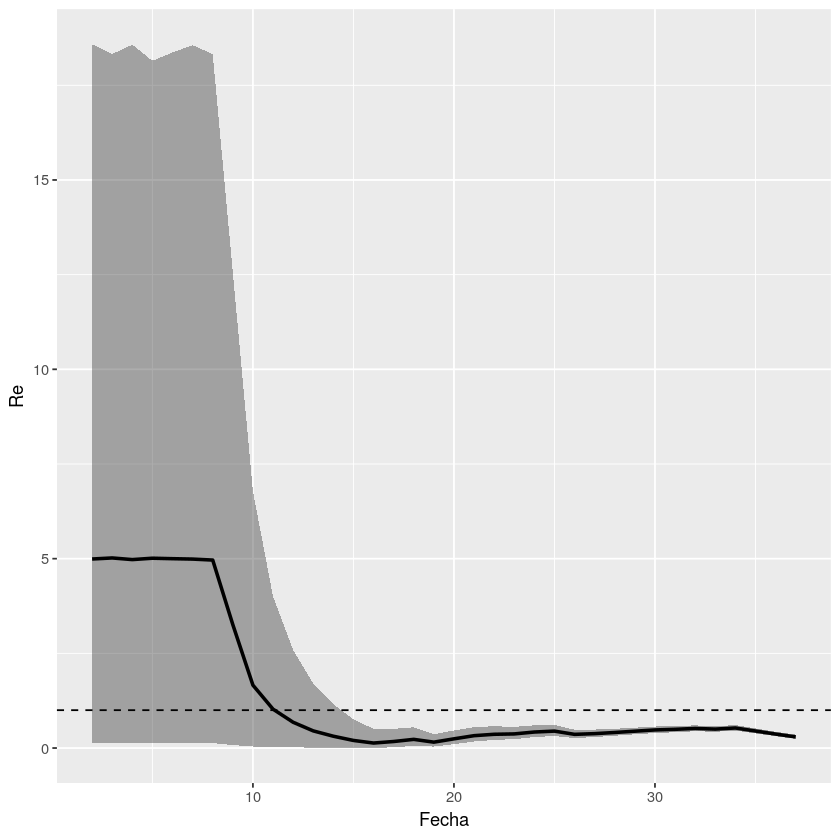

In [165]:
R%>%
  select(Fecha = t_start, Re = `Mean(R)`, Q1 = `Quantile.0.025(R)`, Q3 = `Quantile.0.975(R)`) %>%
  ggplot(., aes(x = Fecha)) +
  geom_ribbon(aes(ymin = Q1, ymax = Q3), alpha = 0.4) +
  geom_line(aes(y = Re), lwd = 1) +
  geom_hline(yintercept = 1, linetype = "dashed")

Se obtiene R instantaneo promedio, y sus cuantiles:

In [166]:
Re_mean = mean(R$`Mean(R)`)
Re_Q1 = mean(R$`Quantile.0.05(R)`)
Re_Q2 = mean(R$`Quantile.0.95(R)`)

Necesitamos scrappear info de poblacion por estado, para rellenar la variable population dado el estado.

In [167]:
Pop <- 8000000 #slider???

I <- Mex_Clean_arriba50 %>%
    filter(Estado == state & Origen == "imported") %>%
    summarise(max(Incidencia)) + Mex_Clean_arriba50 %>%
    filter(Estado == state & Origen == "local") %>%
    summarise(max(Incidencia))

I<- I$`max(Incidencia)`/Pop
E = I*4 #asumimos a 4 expuestos por persona
A = I*0.18
R = 0 / Pop # como rellenamos esto? slider?
D = 0 / Pop # lo mismo que el de arriba?
S = 1-(I+E+A+R+D)

R0_mean = Re_mean / S
R0_97 = Re_Q2 / S
R0_2 = Re_Q1 / S
#Parámetros de ODEs 

gamma = 0.1 #suponiendo una recuperación de 10 dias slider?
alpha = 0.2 #suponiendo una incubación de 5 dias slider?
beta = R0*gamma
beta_97 = R0_97*gamma
beta_2 = R0_2*gamma
rho = 0.82 # suponiendo que el 18% de los infectados es asintomático

GetBeta <- function(intervencion){
    switch(intervencion, "base" = beta,"97.5" = beta_97, "2.5" = beta_2, "moderada" = beta - (beta*0.25), "agresiva" = beta/2)    
}

In [169]:
paste("the value of R0 is ", round(R0_mean,2)) # ponerlo en algun panelito bonito
paste("the value of R0(97.5%) is ", round(R0_97,2)) # ponerlo en algun panelito bonito
paste("the value of R0(2.5%) is ", round(R0_2,2)) # ponerlo en algun panelito bonito

[1] "the value of R0 is  1.41"

[1] "the value of R0(97.5%) is  3.86"

[1] "the value of R0(2.5%) is  0.23"

In [170]:
Condiciones_Iniciales = c(S,E,A,I,R)
pmtrs = c(gamma,alpha,rho,kappa)
t = seq(0, 120, by=0.1) #tiempo de 120 dias

In [171]:
SEAIRD <- function(IC,pmtrs,t, basal = "base", intervencion = "base", init_intervention = 1, intervention_period = 119){
    
    Sv <- c(IC[1])
    Ev <- c(IC[2])
    Av <- c(IC[3])
    Iv <- c(IC[4])
    Rv <- c(IC[5])
    
    dt= t[2]-t[1]
    
    for (i in t[2:length(t)]){
        if (i>= init_intervention & i <= (init_intervention+intervention_period))
        {
            beta = GetBeta(intervencion)
            }
        else
        {
            beta = GetBeta(basal)
            }
        
        S <- Sv[length(Sv)]
        I <- Iv[length(Iv)]
        E <- Ev[length(Ev)]
        A <- Av[length(Av)]
        
        
        St <- S - (beta*S*I)*dt
        Et <- E + (beta*S*I - pmtrs[2]*E)*dt
        At <- A + (1-pmtrs[3])*(pmtrs[2]*E - pmtrs[1]*A)*dt
        It <- I + (pmtrs[3])*(pmtrs[2]*E - pmtrs[1]*I)*dt
        Rt <- (1 - (S-E-A-I))
            
        Sv <- c(Sv,St)
        Ev <- c(Ev,Et)
        Av <- c(Av,At)
        Iv <- c(Iv,It)
        Rv <- c(Rv,Rt)
            }
    ODE <- list("Suceptibles" = Sv, "Expuestos" = Ev, "Asintomáticos" = Av, 
              "Infectados" = Iv, "Recuperados" = Rv)
    return(ODE)    
    }  

In [172]:
ODE <- SEAIRD(Condiciones_Iniciales,pmtrs,t)
ODE97 <- SEAIRD(Condiciones_Iniciales,pmtrs,t, intervencion = "97.5")
ODE2 <- SEAIRD(Condiciones_Iniciales,pmtrs,t, intervencion = "2.5")

In [192]:
ODE_df <- tibble(
    Dias = t,
    "Infectados" = ODE$Infectados*Pop,
    "Infectados(97.5%)" = ODE97$Infectados*Pop,
    "Infectados(2.5%)" = ODE2$Infectados*Pop,
    "Asintomaticos" = ODE$`Asintomáticos`*Pop,
    "Asintomaticos(97.5%)" = ODE97$`Asintomáticos`*Pop,
    "Asintomaticos(2.5%)" = ODE2$`Asintomáticos`*Pop,
    "Expuestos" = ODE$Expuestos*Pop,
    "Expuestos(97.5%)" = ODE97$Expuestos*Pop,
    "Expuestos(2.5%)" = ODE2$Expuestos*Pop
)
head(ODE_df)

Dias,Infectados,Infectados(97.5%),Infectados(2.5%),Asintomaticos,Asintomaticos(97.5%),Asintomaticos(2.5%),Expuestos,Expuestos(97.5%),Expuestos(2.5%)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0,101.0000,101.0000,101.0000,18.18000,18.18000,18.18000,404.0000,404.0000,404.0000
0.1,106.7974,106.7974,106.7974,19.60168,19.60168,19.60168,397.3322,397.3322,397.3322
0.2,112.4379,112.4379,112.4379,20.99679,20.99679,20.99679,390.8788,390.8788,390.8788
0.3,117.9263,117.9263,117.9263,22.36616,22.36616,22.36616,384.6333,384.6333,384.6333
0.4,123.2673,123.2673,123.2673,23.71058,23.71058,23.71058,378.5894,378.5894,378.5894
0.5,128.4654,128.4654,128.4654,25.03082,25.03082,25.03082,372.7412,372.7412,372.7412


INFECTADOS: 

Checar xlim y ylim para que la figura quede bien, como el quantil 97 es muy grande, no deja ver nada, así que lo cortamos, lo mismo a xlim, una frontera de 20 dias

El dia 0 es:

In [190]:
Mex_filled %>% 
    filter(Estado == state) %>%
    summarise(max(dates))

max(dates)
<date>
2020-03-30


Warning message:
“Removed 1000 rows containing missing values (geom_path).”


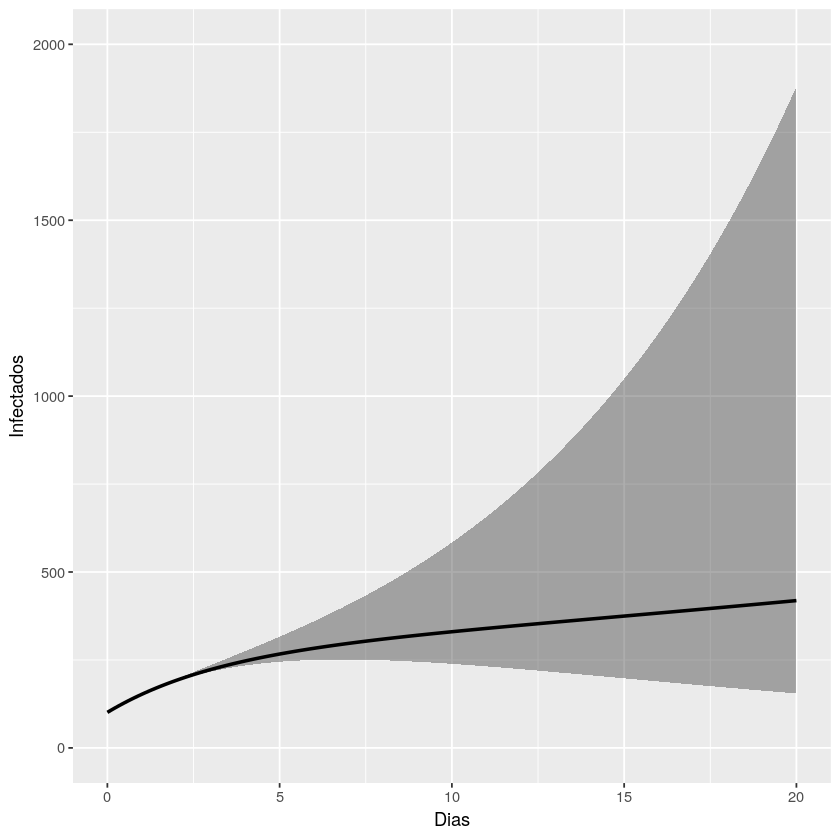

In [186]:
ODE_df%>%
  select(Dias,Infectados, Q2 = `Infectados(97.5%)`, Q1 = `Infectados(2.5%)`) %>%
  ggplot(., aes(x = Dias)) +
  geom_ribbon(aes(ymin = Q1, ymax = Q2), alpha = 0.4) +
  geom_line(aes(y = Infectados), lwd = 1) + ylim(0, 2000) + xlim(0,20)

ASINTOMATICOS
* Checar escalas de nuez

Warning message:
“Removed 1000 rows containing missing values (geom_path).”


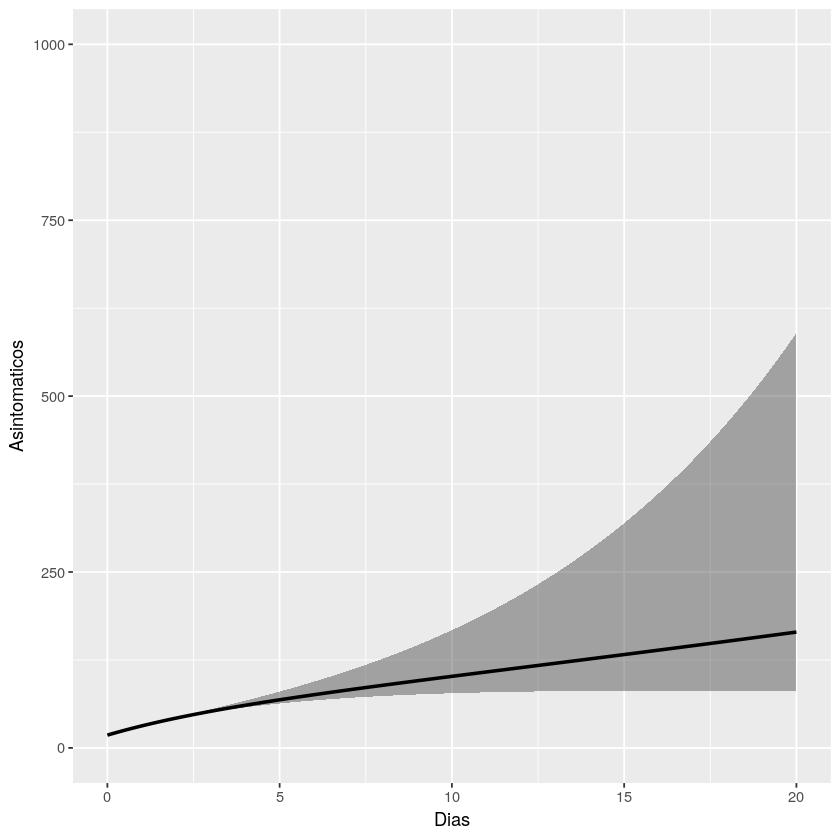

In [194]:
ODE_df%>%
  select(Dias,Asintomaticos, Q2 = `Asintomaticos(97.5%)`, Q1 = `Asintomaticos(2.5%)`) %>%
  ggplot(., aes(x = Dias)) +
  geom_ribbon(aes(ymin = Q1, ymax = Q2), alpha = 0.4) +
  geom_line(aes(y = Asintomaticos), lwd = 1) + ylim(0, 1000) + xlim(0,20)